In [1]:
from utils_model import subsequent_mask, PositionalEncoding
import matplotlib.pyplot as plt
import torch
from utils_training import NoamOpt, LabelSmoothing

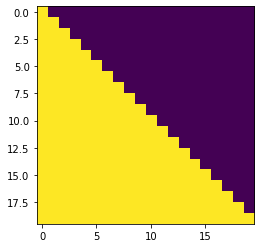

In [3]:
# Token masking
plt.imshow(subsequent_mask(20)[0])
None

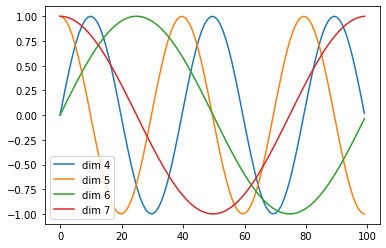

In [8]:
# Positional encoding
pe = PositionalEncoding(d_model=20)
y = pe(torch.zeros(1, 100, 20))

plt.plot(torch.arange(100), y[0, :, 4:8])
plt.legend([f"dim {p}" for p in range(4, 8)])
None

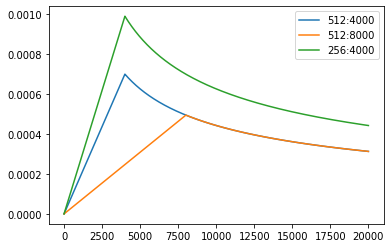

In [10]:
# Noam learning rate scheduler

h_params = ((512, 4000), (512, 8000), (256, 4000))
opts = [
    NoamOpt(d_model=d_model, factor=1, n_warmup_steps=steps, optimizer=None)
    for d_model, steps in h_params
]

plt.plot(torch.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend([f"{d_model}:{steps}" for d_model, steps in h_params])
None

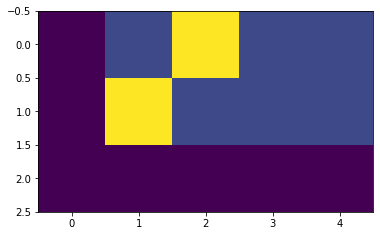

In [2]:
# Label smoothing
crit = LabelSmoothing(n_classes=5, padding_idx=0, smoothing=0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0] for _ in range(3)])
v = crit(predict.log(), torch.LongTensor([2, 1, 0]))

plt.imshow(crit.true_dist)
None

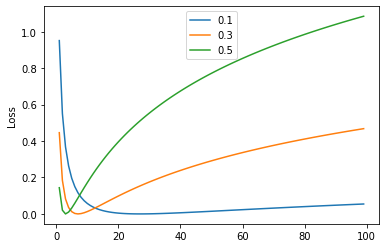

In [11]:
def loss(x, smoothing=0.1):
    crit = LabelSmoothing(5, 0, smoothing)
    
    d = x + 3
    predict = torch.FloatTensor([[0, x/d, 1/d, 1/d, 1/d]])
    
    return crit(predict.log(), torch.LongTensor([1])).item()

smoothing = (0.1, 0.3, 0.5)
plt.plot(torch.arange(1, 100), [[loss(x, s) for s in smoothing] for x in range(1, 100)])
plt.legend(smoothing)
plt.ylabel("Loss")
plt.xlabel("Confidence")
None